In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
from scipy import signal

import IPython.display
import cmocean as cm
import sys, os, glob
import warnings
warnings.simplefilter("ignore")

from IPython.display import Image

from dask.distributed import Client

from matplotlib.patches import Rectangle

In [2]:
# Load workers:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40593,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:44771,Total threads: 1
Dashboard: /proxy/42193/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41425,


## Testing

In [3]:
base = '/g/data/e14/rmh561/croco/'
base_data = base + 'archive/'
base_analysis = base + '/analysis/'

os.chdir(base_analysis + 'PAC12_75_cpl')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts/Tracer_balance_code_LMaillard_v2')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts/pyCOARE-master')

In [4]:
# Load custom scripts/tools:
import pac12_tools as ptools
import R_tools_fort as toolsF
import coare35vn
import meteo

In [14]:
# Reload (if needed):
import importlib
importlib.reload(ptools)

<module 'pac12_tools' from '/g/data/e14/rmh561/croco//analysis/PAC12_75_cpl/Processing_Scripts/pac12_tools.py'>

# Calculate average alpha for APE generation using Lisa's f2py code

In [ ]:
# Get temperature and salinity dataset:
files = sorted(glob.glob(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp02/*/croco_out_mon.nc'))
files = [file for file in files if '2014' not in file]
data = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',drop_variables=['omega','u_sq','v_sq','salt_sq','AKv'],parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})     

In [ ]:
temp = data.temp.isel(s_rho=-1)
salt = data.salt.isel(s_rho=-1)
rho0 = 1025.
alpha = xr.zeros_like(temp).rename('alpha')
for ti in range(len(temp[:,0,0])):
    print(ti)
    alphat, beta = toolsF.alfabeta(temp.isel(time=ti).values,salt.isel(time=ti).values,rho0)
    alpha[ti,:,:] = alphat

In [ ]:
alpha.mean('time').mean('x_rho').mean('y_rho').values

# Test Lisa's fortran-to-python code:

In [ ]:
data_day = xr.open_dataset(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp05/20150201_20150228/croco_out_day.nc').rename({'time_counter':'time'})
data_mon = xr.open_dataset(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp05/20150201_20150228/croco_out_mon.nc').rename({'time_counter':'time'})
data_dayTIW = xr.open_dataset(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp05/20150201_20150228/croco_out_day_TIW.nc').rename({'time_counter':'time'})
data_grd = xr.open_dataset(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp05/20150201_20150228/croco_out_grd.nc')
data_dayTIW = ptools.create_coords_CROCO_TIW(data_dayTIW,data_grd)
rho0 = 1025.
filt_width = 6.

In [ ]:
# Determine first index values:
L1, M1 = 60,147
lon1 = data_day.nav_lon_rho.isel(x_rho=L1,y_rho=M1).values
lat1 = data_day.nav_lat_rho.isel(x_rho=L1,y_rho=M1).values
lonTIW1 = data_dayTIW.nav_lon_rho.isel(x_rho=0,y_rho=0).values
latTIW1 = data_dayTIW.nav_lat_rho.isel(x_rho=0,y_rho=0).values
print('Longitudes: %3.2f %3.2f, Latitudes: %3.2f %3.2f' % (lon1,lonTIW1,lat1,latTIW1))

In [ ]:
# Calculate/subset grid quantities:
L1, M1, S1 = 60, 147, 39
[Mm,Lm] = np.shape(data_dayTIW.temp.isel(time=0).isel(s_rho=0))

hc = data_grd.hc
Cs_r = data_grd.Cs_r
Cs_w = data_grd.Cs_w

pm = data_dayTIW.pm
pn = data_dayTIW.pn
h = data_dayTIW.h

In [ ]:
def TIWt(ds):
    """
    Single time transpose on numpy array for use with Fortran code
    """ 
    return(np.transpose(ds, (2,1,0)))

In [ ]:
zeta = data_day.zeta.isel(x_rho=slice(L1,L1+Lm),y_rho=slice(M1,M1+Mm)).isel(time=0)

z_r = xr.zeros_like(data_mon.z_rho.isel(x_rho=slice(L1,L1+Lm),y_rho=slice(M1,M1+Mm)).isel(s_rho=slice(S1,None)).isel(time=0))
z_w = xr.zeros_like(data_dayTIW.omega.isel(time=0))

z_rt, z_wt = toolsF.zlevs(h.T,zeta.T,hc,Cs_r,Cs_w)
z_r.values = TIWt(z_rt[:,:,S1:])
z_w.values = TIWt(z_wt[:,:,S1:])

In [ ]:
# Plus 1 time for vertical velocity:
zetap1 = data_day.zeta.isel(x_rho=slice(L1,L1+Lm),y_rho=slice(M1,M1+Mm)).isel(time=1)

z_rp1 = xr.zeros_like(data_mon.z_rho.isel(x_rho=slice(L1,L1+Lm),y_rho=slice(M1,M1+Mm)).isel(s_rho=slice(S1,None)).isel(time=0))
z_wp1 = xr.zeros_like(data_dayTIW.omega.isel(time=0))

z_rtp1, z_wtp1 = toolsF.zlevs(h.T,zetap1.T,hc,Cs_r,Cs_w)
z_rp1.values = TIWt(z_rtp1[:,:,S1:])
z_wp1.values = TIWt(z_wtp1[:,:,S1:])

In [ ]:
# Setup grid object:
grid = Grid(data_dayTIW,coords={"x":{"center":"x_rho","outer":"x_u"},
                                    "y":{"center":"y_rho","outer":"y_v"},
                                    "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

In [ ]:
# Omega and vertical velocity calculations:
u = data_dayTIW.u.isel(x_u=slice(1,-1)).isel(time=0)
v = data_dayTIW.v.isel(y_v=slice(1,-1)).isel(time=0)
omega = toolsF.get_omega(TIWt(u.values),TIWt(v.values),TIWt(z_r.values),TIWt(z_w.values),pm.T,pn.T)

omega_pre = data_dayTIW.omega.isel(time=0)
omega_pos = xr.zeros_like(omega_pre)
omega_pos.values = np.transpose(omega, (2, 1, 0))

In [ ]:
# Plot:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15))
omega_pre.isel(s_w=20).plot(ax=axes[0][0],vmin=-.5e-3,vmax=.5e-3,cmap='RdBu_r')
axes[0][0].set_title('Pre-calculated')
omega_pos.isel(s_w=20).plot(ax=axes[1][0],vmin=-.5e-3,vmax=.5e-3,cmap='RdBu_r')
axes[1][0].set_title('Post-calculated')
(omega_pos-omega_pre).isel(s_w=20).plot(ax=axes[0][1],vmin=-.5e-3,vmax=.5e-3,cmap='RdBu_r')
axes[0][1].set_title('Difference')

In [ ]:
# # w from get_wvlcty (I think this could be wrong because of the integral from bottom up):
# w = toolsF.get_wvlcty(TIWt(u.values),TIWt(v.values),TIWt(z_r.values),TIWt(z_w.values),pm.T,pn.T)
# w_pos = xr.zeros_like(data_dayTIW.temp.isel(time=0))
# w_pos.values = np.transpose(w, (2, 1, 0))

# reconstructing w from omega.
# From https://www.myroms.org/wiki/Terrain-Following_Coordinate_Transformation:
# w = dz/dt + u dz/dx + v dz/dy + omega
# (Note: at the above link, the last term is omega*Hz, but the omega in the outputs is already multiplied by the Hz factor, see https://www.myroms.org/forum/viewtopic.php?t=2139

w_u_cor = u.rename({'y_u':'y_rho'})*grid.diff(z_r,'x')*grid.interp(pm,'x')
w_v_cor = v.rename({'x_v':'x_rho'})*grid.diff(z_r,'y')*grid.interp(pn,'y')
w_t_cor = (z_rp1-z_r)/86400.

In [ ]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15))

index = 10

omega_pre.isel(s_w=index).plot(ax=axes[0][0],vmin=-.5e-3,vmax=.5e-3,cmap='RdBu_r')
axes[0][0].set_title('Omega [ms-1]')

w_u_cor.isel(s_rho=index).plot(ax=axes[1][0],vmin=-.5e-3,vmax=.5e-3,cmap='RdBu_r')
axes[1][0].set_title('u-correction to omega')
w_v_cor.isel(s_rho=index).plot(ax=axes[0][1],vmin=-.5e-3,vmax=.5e-3,cmap='RdBu_r')
axes[0][1].set_title('v-correction to omega')
w_t_cor.isel(s_rho=index).plot(ax=axes[1][1],vmin=-.5e-3,vmax=.5e-3,cmap='RdBu_r')
axes[1][1].set_title('z_t-correction to omega')
z_r.isel(s_rho=index).plot(ax=axes[2][0])
axes[2][0].set_title('rho Depth at this level')

In [ ]:
# Buoyancy calculation:
temp = data_dayTIW.temp.isel(time=0)
salt = data_dayTIW.salt.isel(time=0)
b = xr.zeros_like(temp)

b.values = TIWt(toolsF.get_buoy(TIWt(temp.values),TIWt(salt.values),TIWt(z_r.values),TIWt(z_w.values),rho0))

In [ ]:
# Grid object:
grid = Grid(data_dayTIW,coords={"x":{"center":"x_rho","outer":"x_u"},
                         "y":{"center":"y_rho","outer":"y_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False) #NOTE: This is different to parent grid becuase _u and _v are outer not inner.

# Filtering:
u = data_dayTIW.u.isel(time=0)
v = data_dayTIW.v.isel(time=0)
omega = data_dayTIW.omega.isel(time=0)

u_lp = ptools.zlp_filt(u,filt_width)
u_hp = u - u_lp

v_lp = ptools.zlp_filt(v,filt_width)
v_hp = v - v_lp

omega_lp = ptools.zlp_filt(omega,filt_width)
omega_hp = omega - omega_lp

b_lp = ptools.zlp_filt(b,filt_width)
b_hp = b - b_lp

In [ ]:
# Do the calculations:
uu = grid.interp(u_hp*u_hp,'x').rename({'y_u':'y_rho'})
vv = grid.interp(v_hp*v_hp,'y').rename({'x_v':'x_rho'})
uv = grid.interp(u_hp,'x').rename({'y_u':'y_rho'})*grid.interp(v_hp,'y').rename({'x_v':'x_rho'})
uw = grid.interp(u_hp,'x').rename({'y_u':'y_rho'})*grid.interp(omega_hp,'s').rename({'x_w':'x_rho','y_w':'y_rho'})
vw = grid.interp(v_hp,'y').rename({'x_v':'x_rho'})*grid.interp(omega_hp,'s').rename({'x_w':'x_rho','y_w':'y_rho'})
wb = b_hp*grid.interp(omega_hp,'s').rename({'x_w':'x_rho','y_w':'y_rho'})

In [ ]:
Ux = grid.diff(u_lp,'x').rename({'y_u':'y_rho'})*data_dayTIW.pm
Vy = grid.diff(v_lp,'y').rename({'x_v':'x_rho'})*data_dayTIW.pn

In [ ]:
Uy = grid.interp(grid.interp(grid.diff(u_lp.rename({'y_u':'y_rho'}),'y'),'x'),'y')*data_dayTIW.pn
Vx = grid.interp(grid.interp(grid.diff(v_lp.rename({'x_v':'x_rho'}),'x'),'x'),'y')*data_dayTIW.pm

In [ ]:
Uz = grid.interp(grid.interp(grid.diff(u_lp,'s').rename({'y_u':'y_rho'}),'x')/grid.diff(z_r,'s'),'s')
Vz = grid.interp(grid.interp(grid.diff(v_lp,'s').rename({'x_v':'x_rho'}),'y')/grid.diff(z_r,'s'),'s')

In [ ]:
# Do some plotting:
fig, axes = plt.subplots(figsize=(20,20),nrows=4,ncols=2)

axs = axes.reshape(-1)
[(uu*Ux).isel(s_rho=25).plot(ax=axs[0],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axs[0].set_title('uu Ux')
(uv*Uy).isel(s_rho=25).plot(ax=axs[1],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axs[1].set_title('uv Uy')
(uv*Vx).isel(s_rho=25).plot(ax=axs[2],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axs[2].set_title('uv Vx')
(vv*Vy).isel(s_rho=25).plot(ax=axs[3],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axs[3].set_title('vv Vy')
(uw*Uz).isel(s_rho=25).plot(ax=axs[4],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axs[4].set_title('uw Uz')
(vw*Vz).isel(s_rho=25).plot(ax=axs[5],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axs[5].set_title('vu Vz')
(wb).isel(s_rho=25).plot(ax=axs[6],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axs[6].set_title('wb')

# Test high-pass filter processing scripts

In [ ]:
# Testing 3d EKE budget high-pass filter processing (calc_zhp_3d_variables):
file_in_day = base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp13/20150101_20150131/croco_out_day.nc'
filt_width = 12.

ds = ptools.calc_zhp_std_variables(file_in_day,file_in_mon,file_out,filt_width)

In [ ]:
# Reload (if needed):
import importlib
importlib.reload(ptools)

In [ ]:
# Testing high-pass filter stuff:
base_spec = base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp05/20150101_20150131/'
file_in_day = base_spec + 'croco_out_day.nc'
file_in_dayTIW = base_spec + 'croco_out_day_TIW.nc'
file_in_mon = base_spec + 'croco_out_mon.nc'
file_in_grd = base_spec + 'croco_out_grd.nc'
file_out = base_spec + 'croco_out_mon_TIWhp.nc'
filt_width = 6.

ptools.calc_zhp_3d_variables(file_in_dayTIW,file_in_day,file_in_mon,file_in_grd,file_out,filt_width)

# Testing Gaussian rather than box-car filter:

In [ ]:
file_in = base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp13/20150101_20150131/croco_out_day.nc'
file_out = 'test.nc'
filt_width = 12. # Box-car filter width in degrees
gauss_width = 6. # Gaussian filter standard deviation in degrees
cutratio = 0.1   # Minimum amplitude of gaussian filter to keep.

data = xr.open_dataset(file_in,chunks={'time_counter':1}).rename({'time_counter':'time'})
data = ptools.create_coords_CROCO(data)

SST = data.temp_surf.isel(time=0)

In [ ]:
SST_boxcar = ptools.zlp_filt(SST,filt_width,typ='box')
SST_gauss = ptools.zlp_filt(SST,gauss_width,typ='gau',cut=0.1)

In [ ]:
var = SST
width = gauss_width
cut = cutratio
#def zlp_filt_gauss(var,width,cut):
    # Calculate zonal filtered version of a variable

dims = var.dims
inds = [index for index,item in enumerate(dims) if item.startswith('x')]
if (len(inds) != 1):
    raise RuntimeError("Error in zhp_filt: less than or greater than 1 zonal dimension found")
else:
    x = dims[inds[0]]

dx = (var[x][1]-var[x][0]).values

sigx = int(width/dx)
nn = int(3*2*sigx+1)

xx = np.arange(0.,nn)
dd = np.sqrt(((xx-int(nn/2))**2)/sigx**2)
ww = 1./(np.sqrt(np.pi)*sigx)*np.exp(-dd**2)
keepww = np.argwhere((ww.ravel() >= max(ww.ravel())*cutratio)); nnok=len(keepww)
ww = ww.ravel()[keepww.astype('int')]
ww = ww/ww.sum()

weight = xr.DataArray(ww.ravel(), dims=['window'])

SST_gauss = var.rolling({x:nnok},center=True).construct('window').dot(weight)
SST_gauss

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
SST.plot(vmin=22.,vmax=28.,cmap='RdBu_r')
plt.gca().set_ylim([-10.,15.])
plt.title('Raw')
plt.subplot(2,2,2)
SST_boxcar.plot(vmin=22.,vmax=28.,cmap='RdBu_r')
plt.gca().set_ylim([-10.,15.])
plt.title('Box-car 12-degree filter')
plt.plot([200.,220.,220.,220.+filt_width,220.+filt_width,260.],[0.,0.,5.,5.,0.,0.],'-k')
plt.subplot(2,2,3)
SST_gauss.plot(vmin=22.,vmax=28.,cmap='RdBu_r')
plt.gca().set_ylim([-10.,15.])
plt.title('Gaussian 6-degree filter')
#x = 220.+xx*dx
#x = x.ravel()[keepww.astype('int')]
#plt.plot(x,ww*1000.,'-k')
plt.subplot(2,2,4)
(SST_boxcar-SST_gauss).plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')
plt.gca().set_ylim([-10.,15.])
plt.title('Difference between box-car and gaussian filter')

# Test WRF vs. CROCO filtering:

In [ ]:
file_in_croco = base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp02/20150101_20150131/croco_out_day.nc'
file_in_wrf = base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp02/20150101_20150131/wrf3d_1D_2015-01-01-2015-01-31.nc_20150101_20150131.nc'
gauss_width = 6. # Gaussian filter standard deviation in degrees

# CROCO SST:
data = xr.open_dataset(file_in_croco,chunks={'time_counter':1}).rename({'time_counter':'time'})
data = ptools.create_coords_CROCO(data)

SST_croco = data.temp_surf.isel(time=0)

# WRF SST:
data_wrf = xr.open_dataset(file_in_wrf,chunks={'time_counter':1}).rename({'time_counter':'time'})
data_wrf = ptools.create_coords_WRF(data_wrf)

SST_wrf = data_wrf.SST.isel(time=0)-273.15

In [ ]:
SST_croco_lp = ptools.zlp_filt(SST_croco,gauss_width)
SST_croco_hp = SST_croco - SST_croco_lp
SST_wrf_lp = ptools.zlp_filt(SST_wrf,gauss_width)
SST_wrf_hp = SST_wrf - SST_wrf_lp

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
SST_croco_lp.plot(vmin=22.,vmax=28.,cmap='RdBu_r')
plt.gca().set_ylim([-10.,15.])
plt.title('CROCO LP')
plt.subplot(2,2,2)
SST_wrf_lp.plot(vmin=22.,vmax=28.,cmap='RdBu_r')
plt.gca().set_ylim([-10.,15.])
plt.title('WRF LP')

plt.subplot(2,2,3)
SST_croco_hp.plot(vmin=-1.,vmax=1.,cmap='RdBu_r')
plt.gca().set_ylim([-10.,15.])
plt.title('CROCO HP')
plt.subplot(2,2,4)
SST_wrf_hp.plot(vmin=-1.,vmax=1.,cmap='RdBu_r')
plt.gca().set_ylim([-10.,15.])
plt.title('WRF HP')

# Test V*SST heat flux:


In [ ]:
# Testing Gaussian rather than box-car filter:
file_in = base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp13/20150101_20150131/croco_out_day.nc'

data = xr.open_dataset(file_in,chunks={'time_counter':1}).rename({'time_counter':'time'})
data = ptools.create_coords_CROCO(data)

SST = data.temp_surf.isel(time=0)
V = data.v_surf.isel(time=0)
U = data.u_surf.isel(time=0)

In [ ]:
SST_hp = SST - ptools.zlp_filt(SST,6.)
V_hp = V - ptools.zlp_filt(V,6.)
U_hp = U - ptools.zlp_filt(U,6.)

In [ ]:
grid = Grid(data,coords={"y":{"center":"y_rho","inner":"y_v"},"x":{"center":"x_rho","inner":"x_u"}},periodic=False)

In [ ]:
VSST = grid.interp(V_hp,'y').rename({'x_v':'x_rho'})*SST_hp
USST = grid.interp(U_hp,'x').rename({'y_u':'y_rho'})*SST_hp

In [ ]:
VSST.plot()

# Test pyCOARE-master

In [5]:
# Load some data from an example month:
croco_day = xr.open_dataset(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp09/20150201_20150228/croco_out_day.nc').rename({'time_counter':'time'})
croco_grd = xr.open_dataset(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp09/20150201_20150228/croco_out_grd.nc')
croco_dayTIW = ptools.create_coords_CROCO(croco_day)
wrf_day = xr.open_dataset(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp09/20150201_20150228/wrf3d_1D_2015-02-01-2015-02-28.nc_20150201_20150228.nc').rename({'time_counter':'time'})
wrf_hr = xr.open_dataset(base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp09/20150201_20150228/wrf3d_1H_2015-02-01-2015-02-28.nc_20150201_20150228.nc').rename({'time_counter':'time'})
mask = wrf_day.SST.isel(time=0)>100.

In [6]:
wrf_day

<xarray.Dataset>
Dimensions:               (y: 167, x: 521, time: 28, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
    time_centered         (time) datetime64[ns] ...
  * time                  (time) datetime64[ns] 2015-02-01T12:00:00 ... 2015-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/30)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] ...
    PSFC                  (time, y, x) float32 ...
    PBLH                  (time, y, x) float32 ...
    T2                    (time, y, x) float32 ...
    Q2                    (time, y, x) float32 ...
    ...                    ...
    CD                    (time, y, x) float32 ...
    SST                   (time, y, x) float32 ...
    TSK                   (time, y, x) float32 ...
    UOCE                  (time, y, x) float32 ...
    VOCE                  (time, y, x) float32 ...
    ZNT                   (time, y, x) float32 ...
Attributes: (12/103)
    name:                            wrf3d_1D
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2022-Dec-16 09:24:48 GMT
    uuid:                            917b3ddc-cf0e-4749-a446-90f02b42ad21
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [77]:
def coare_tflux(obj,SST,skintemp=True):
    """ A wrapper around coare35vn that takes a wrf daily output file and an SST input
        and returns the turbulent heat fluxes calculated using the coare35vn routine 
        Note: 
        if skintemp=True then SST should be skin temp (this is more accurate)
        if skintemp=False then SST is not skin temp
        """
    
    # Input unit conversions and shapes:
    K_to_C = -273.15
    u = obj.WSPD_REL
    sz = u.shape
    if len(sz)==3:
        lat = np.transpose(np.repeat(obj.nav_lat.values[:,:,np.newaxis],sz[0],axis=2),(2,0,1))
    else:
        lat = obj.nav_lat.values
    shp = -1
    lat = lat.reshape(shp)
    u = u.values.reshape(shp)
    t = (obj.T_PHYL1+K_to_C).values.reshape(shp)
    q = obj.QVL1.values.reshape(shp)
    p = (obj.PSFC/100.).values.reshape(shp) # PSFC is in Pa, p is in mbar.
    
    ts = (SST+K_to_C).values.reshape(shp)
    if skintemp:
        jcool=0
    else:
        jcool=1

    rh = (meteo.rhcalc(t,p,q)).reshape(shp)
    zi = obj.PBLH.values.reshape(shp) # This makes very little difference compared to default, slightly better with it included.
    
    # These make no difference, remove:
    # Rs = obj.GSW.values.reshape(shp)
    # Rl = obj.GLW.values.reshape(shp) 
    # rain = obj.RAIN.values.reshape(shp) # This appears to make no difference. Removed.
    
    # Call function:
    A = coare35vn.coare35vn(u, t, rh, ts, P=p,zu=10.,zt = 10.,zq=10.,lat=lat,jcool=jcool,zi=zi)
    
    # Outputs:
    HFX = xr.zeros_like(obj.HFX)
    LH = xr.zeros_like(obj.LH)
    HFX.data = A[:,2].reshape(sz)
    LH.data = A[:,3].reshape(sz)
    
    return(HFX,LH)

In [78]:
# Calculate fluxes for a single day using daily output:
HFX,LH = coare_tflux(wrf_day.isel(time=0),wrf_day.isel(time=0).TSK)

# Mask out land:
HFX = HFX.where(mask)
LH = LH.where(mask)

Sensible Error RMSE = 0.94 Wm$^{-2}$
Latent Error RMSE = 28.42 Wm$^{-2}$


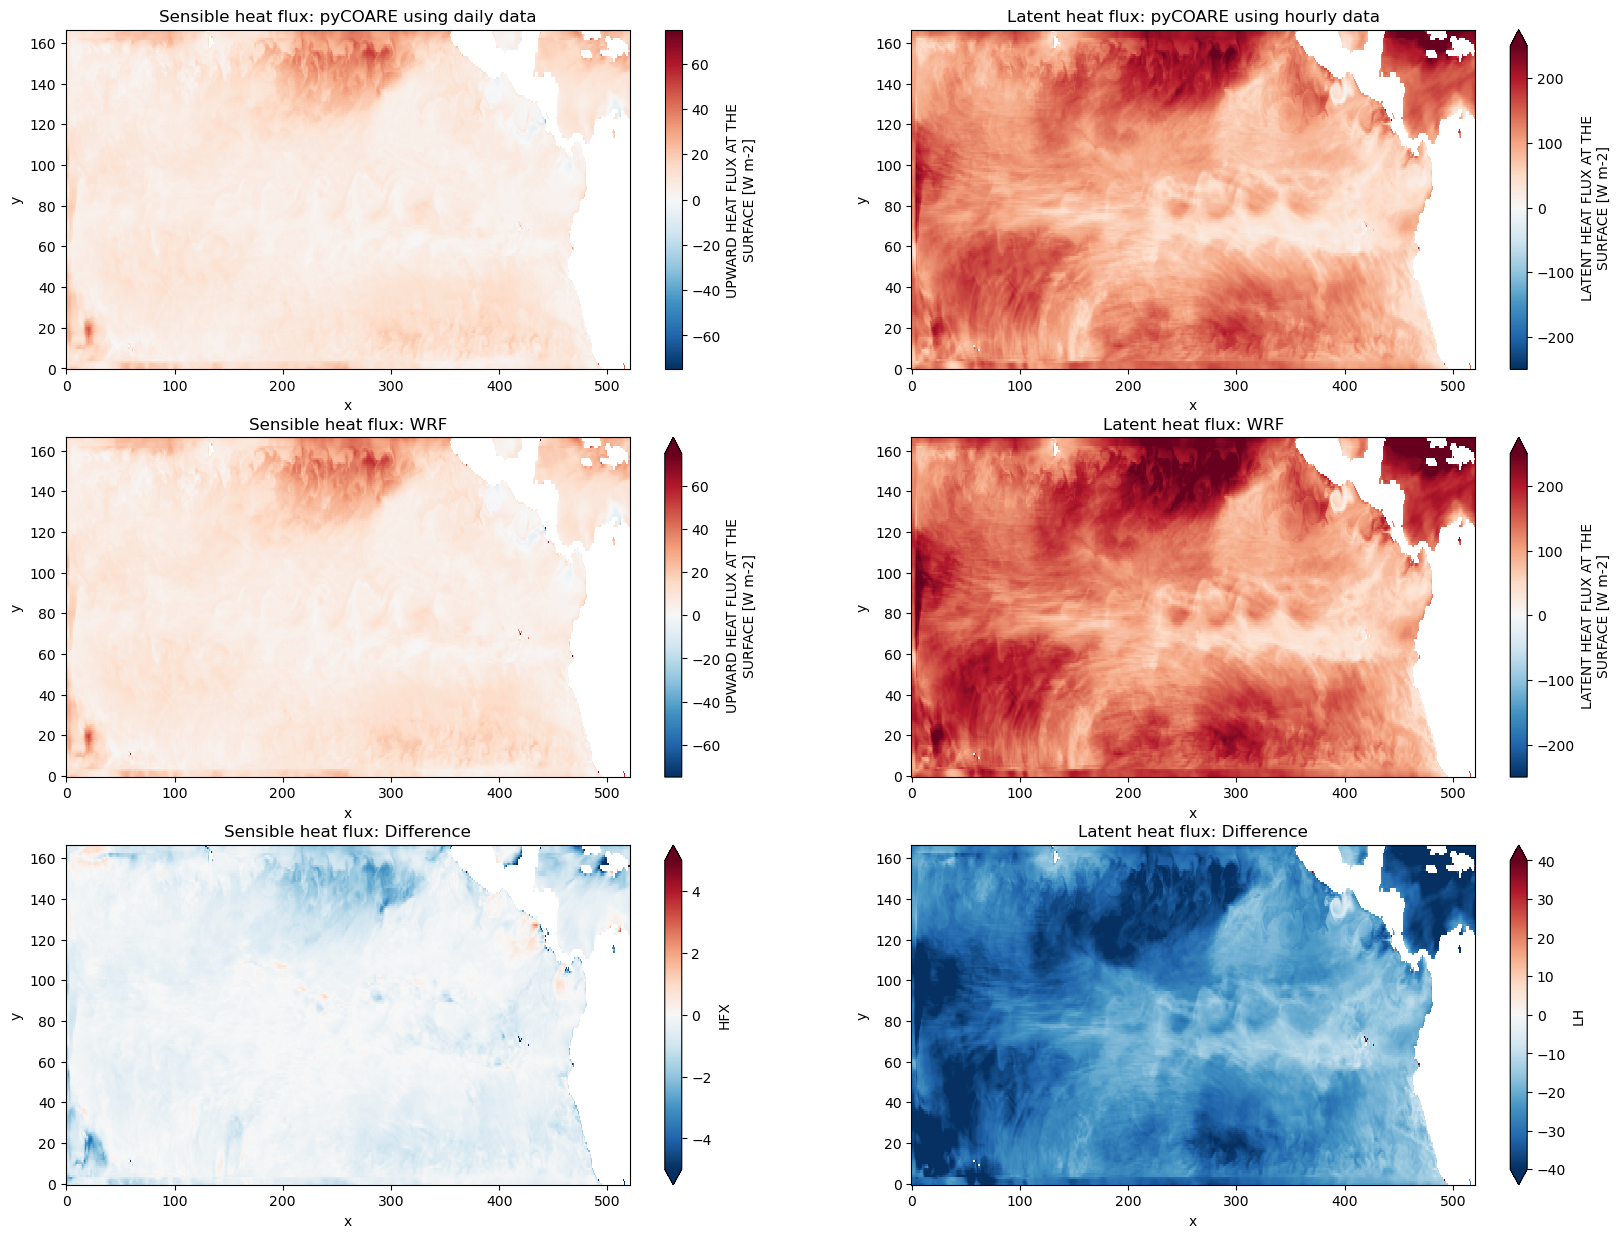

In [79]:
# Compare fluxes calculated using daily data:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15))

(HFX).plot(ax=axes[0][0],vmin=-75.,vmax=75.,cmap='RdBu_r')
axes[0][0].set_title('Sensible heat flux: pyCOARE using daily data')
wrf_day.isel(time=0).HFX.where(mask).plot(ax=axes[1][0],vmin=-75.,vmax=75.,cmap='RdBu_r')
axes[1][0].set_title('Sensible heat flux: WRF')
(HFX-wrf_day.isel(time=0).HFX.where(mask)).plot(ax=axes[2][0],vmin=-5.,vmax=5.,cmap='RdBu_r')
axes[2][0].set_title('Sensible heat flux: Difference')

# Error RMSE:
print('Sensible Error RMSE = %3.2f Wm$^{-2}$' % (np.sqrt(((HFX-wrf_day.isel(time=0).HFX.where(mask))**2.).mean('x').mean('y'))))

(LH).plot(ax=axes[0][1],vmin=-250.,vmax=250.,cmap='RdBu_r')
axes[0][1].set_title('Latent heat flux: pyCOARE using hourly data')
wrf_day.isel(time=0).LH.where(mask).plot(ax=axes[1][1],vmin=-250.,vmax=250.,cmap='RdBu_r')
axes[1][1].set_title('Latent heat flux: WRF')
(LH-wrf_day.isel(time=0).LH.where(mask)).plot(ax=axes[2][1],vmin=-40.,vmax=40.,cmap='RdBu_r')
axes[2][1].set_title('Latent heat flux: Difference')

# Error RMSE:
print('Latent Error RMSE = %3.2f Wm$^{-2}$' % (np.sqrt(((LH-wrf_day.isel(time=0).LH.where(mask))**2.).mean('x').mean('y'))))

In [184]:
# Calculate fluxes using the hourly data we have available:
test = wrf_hr.isel(time=slice(0,24))
test['WSPD_REL'] = np.sqrt((test.U_PHYL1-test.UOCE)*(test.U_PHYL1-test.UOCE) +(test.V_PHYL1-test.VOCE)*(test.V_PHYL1-test.VOCE))

# For those variables that I don't have hourly output for, use the daily average instead:
test['PSFC'] = xr.zeros_like(test.WSPD_REL)
test['PSFC'].data = np.transpose(np.repeat(wrf_day.isel(time=0).PSFC.values[:,:,np.newaxis],24,axis=2),(2,0,1))
test['GSW'] = xr.zeros_like(test.WSPD_REL)
test['GSW'].data = np.transpose(np.repeat(wrf_day.isel(time=0).GSW.values[:,:,np.newaxis],24,axis=2),(2,0,1))
test['GLW'] = xr.zeros_like(test.WSPD_REL)
test['GLW'].data = np.transpose(np.repeat(wrf_day.isel(time=0).GLW.values[:,:,np.newaxis],24,axis=2),(2,0,1))
test['PBLH'] = xr.zeros_like(test.WSPD_REL)
test['PBLH'].data = np.transpose(np.repeat(wrf_day.isel(time=0).PBLH.values[:,:,np.newaxis],24,axis=2),(2,0,1))
test['HFX'] = xr.zeros_like(test.WSPD_REL)
test['HFX'].data = np.transpose(np.repeat(wrf_day.isel(time=0).HFX.values[:,:,np.newaxis],24,axis=2),(2,0,1))
test['LH'] = xr.zeros_like(test.WSPD_REL)
test['LH'].data = np.transpose(np.repeat(wrf_day.isel(time=0).LH.values[:,:,np.newaxis],24,axis=2),(2,0,1))

# Calculate fluxes for each hour:
HFXhr,LHhr = coare(test)

# Take the mean across the day:
HFXhr = HFXhr.mean('time')
LHhr = LHhr.mean('time')

Sensible Error RMSE = 2.08 Wm$^{-2}$
Latent Error RMSE = 24.43 Wm$^{-2}$


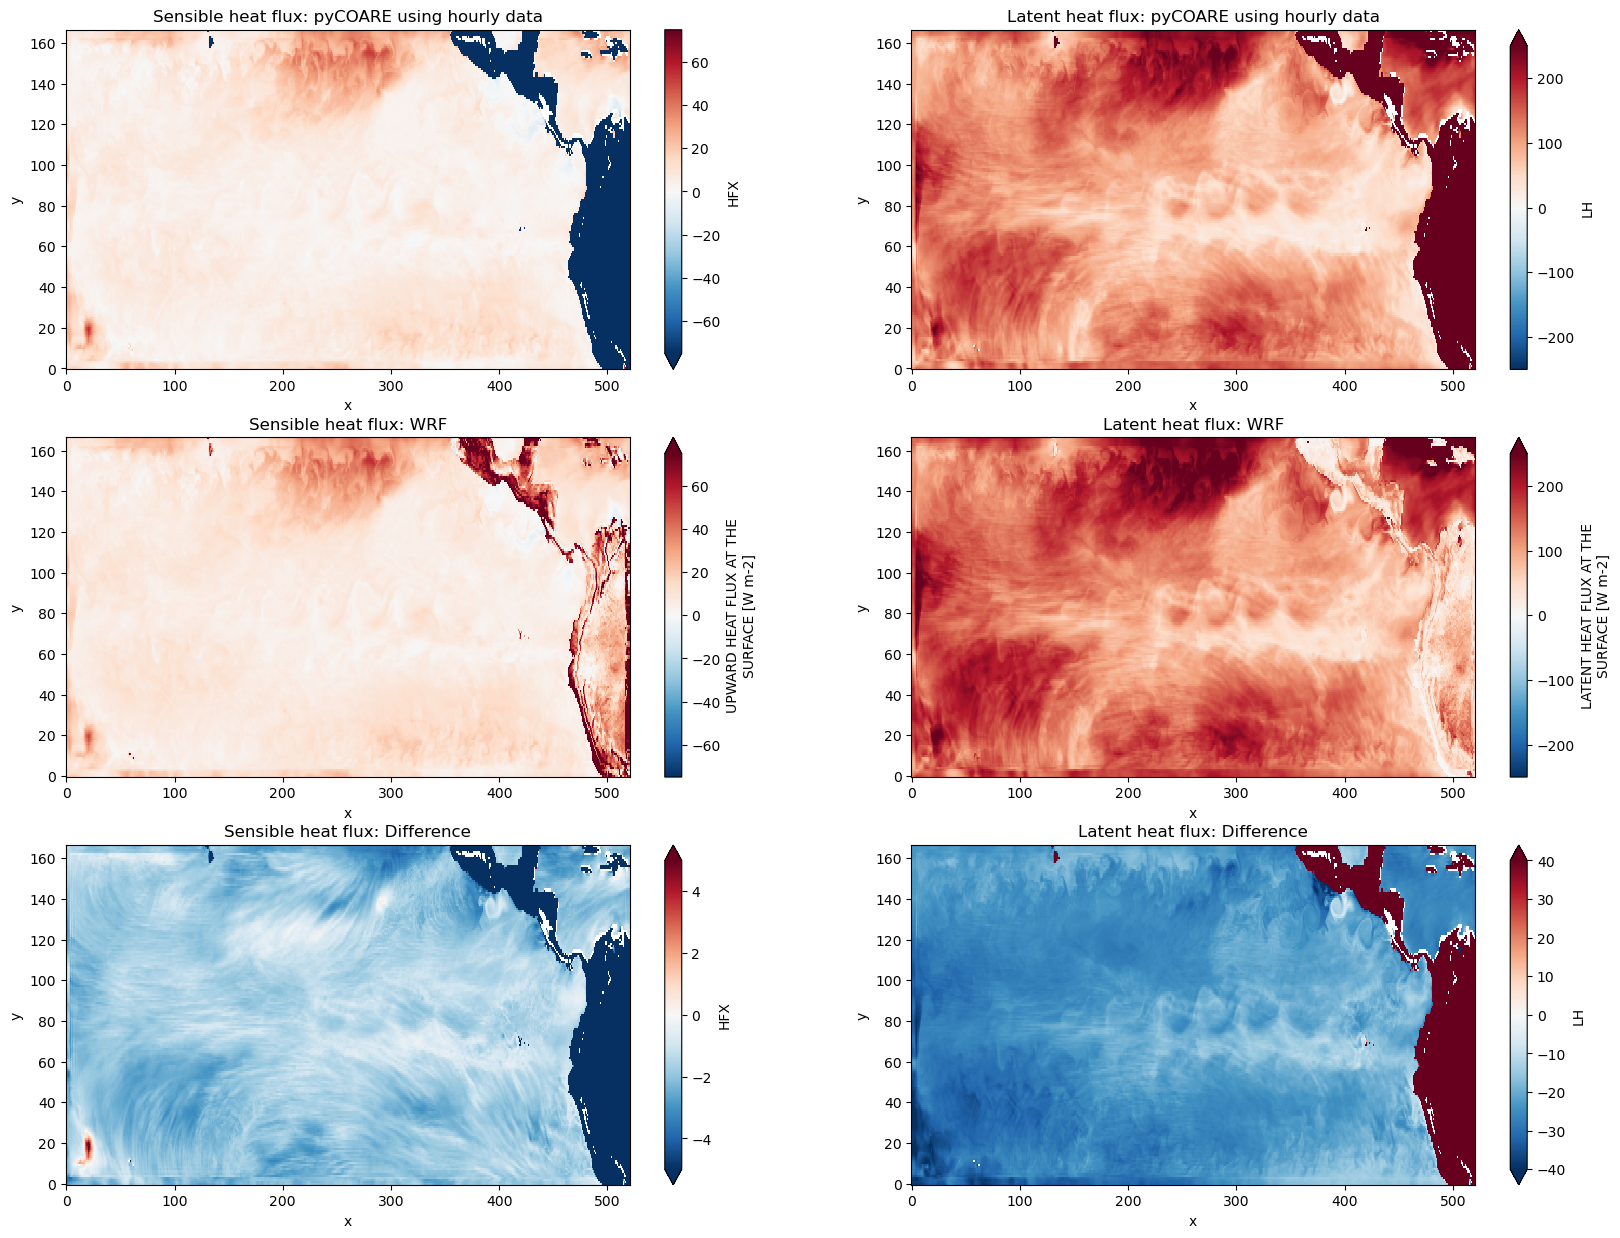

In [188]:
# Compare fluxes calculated using hourly data:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15))

(HFXhr).plot(ax=axes[0][0],vmin=-75.,vmax=75.,cmap='RdBu_r')
axes[0][0].set_title('Sensible heat flux: pyCOARE using hourly data')
wrf_day.isel(time=0).HFX.plot(ax=axes[1][0],vmin=-75.,vmax=75.,cmap='RdBu_r')
axes[1][0].set_title('Sensible heat flux: WRF')
(HFXhr-wrf_day.isel(time=0).HFX).plot(ax=axes[2][0],vmin=-5.,vmax=5.,cmap='RdBu_r')
axes[2][0].set_title('Sensible heat flux: Difference')

# Error RMSE:
print('Sensible Error RMSE = %3.2f Wm$^{-2}$' % (np.sqrt(((HFXhr.where(HFXhr>-50.)-wrf_day.isel(time=0).HFX)**2.).mean('x').mean('y'))))

(LHhr).plot(ax=axes[0][1],vmin=-250.,vmax=250.,cmap='RdBu_r')
axes[0][1].set_title('Latent heat flux: pyCOARE using hourly data')
wrf_day.isel(time=0).LH.plot(ax=axes[1][1],vmin=-250.,vmax=250.,cmap='RdBu_r')
axes[1][1].set_title('Latent heat flux: WRF')
(LHhr-wrf_day.isel(time=0).LH).plot(ax=axes[2][1],vmin=-40.,vmax=40.,cmap='RdBu_r')
axes[2][1].set_title('Latent heat flux: Difference')

# Error RMSE:
print('Latent Error RMSE = %3.2f Wm$^{-2}$' % (np.sqrt(((LHhr.where(LHhr<500.)-wrf_day.isel(time=0).LH)**2.).mean('x').mean('y'))))

## Test Smoothed and offline Ge and Gm terms:

In [9]:
# Load some data from an example month:
croco_mon =base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp09/20150201_20150228/croco_out_mon.nc'
wrf_day = base_data + 'PAC12_75_cpl/PAC12_75_cpl_exp09/20150201_20150228/wrf3d_1D_2015-02-01-2015-02-28.nc_20150201_20150228.nc'
file_out = 'test.nc'
filt_width = 6.

In [15]:
ptools.calc_zhp_wrf_variables(wrf_day,croco_mon,file_out,filt_width)

In [16]:
data = xr.open_dataset('test.nc')
data

<xarray.Dataset>
Dimensions:        (y: 167, x: 521, time_counter: 1, x_u: 520, y_v: 166)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * x              (x) float32 174.5 174.7 174.9 175.2 ... 291.1 291.3 291.5
  * y              (y) float32 -15.97 -15.75 -15.54 -15.32 ... 20.29 20.51 20.72
  * x_u            (x_u) float32 174.6 174.8 175.0 175.3 ... 291.0 291.2 291.4
  * y_v            (y_v) float32 -15.86 -15.65 -15.43 ... 20.19 20.4 20.61
  * time_counter   (time_counter) datetime64[ns] 2015-02-15
Data variables: (12/16)
    SST_hp_var     (time_counter, y, x) float64 ...
    Wdiv_hp_var    (time_counter, y_v, x_u) float64 ...
    Wcur_hp_var    (time_counter, y_v, x_u) float64 ...
    Sdiv_hp_var    (time_counter, y_v, x_u) float64 ...
    Scur_hp_var    (time_counter, y_v, x_u) float64 ...
    WX_hp_var      (time_counter, y, x) float64 ...
    ...             ...
    QSST_hp        (time_counter, y, x) float64 ...
    Qof_hp_var     (time_counter, y, x) float64 ...
    QofSST_hp      (time_counter, y, x) float64 ...
    Qofsmt_hp_var  (time_counter, y, x) float64 ...
    QofsmtSST_hp   (time_counter, y, x) float64 ...
    DT             int64 ...

In [59]:
TSK_lp = ptools.zlp_filt(data_day.TSK.isel(time_counter=0),6.)
TSK_lp.fillna(273.15)

<xarray.DataArray (y: 167, x: 521)>
array([[273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15],
       [273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15],
       [273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15],
       ...,
       [273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15],
       [273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15],
       [273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15]])
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2015-02-01T12:00:00
Dimensions without coordinates: y, x

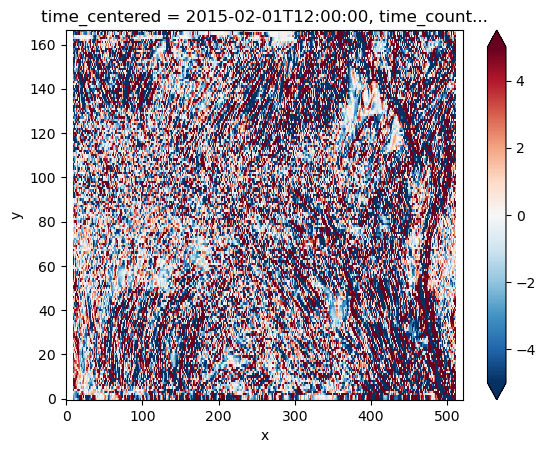

In [48]:
data_day = xr.open_dataset(wrf_day)
var = data_day.GLW-5.67e-8*(data_day.TSK)**4
var = var.isel(time_counter=0)
(var-ptools.zlp_filt(var,6.)).plot(vmin=-5.,vmax=5.,cmap='RdBu_r')

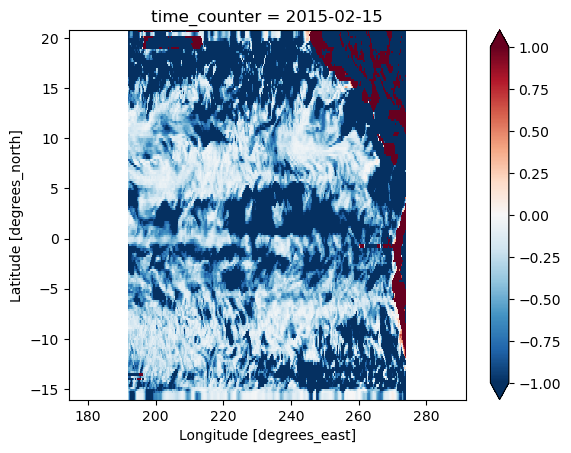

In [54]:
(data.QofsmtSST_hp-data.QofSST_hp).plot(vmin=-1.,vmax=1.,cmap='RdBu_r')